Despues de leer mi dataset, me doy cuenta que existen csv con las etiquetas de los datos, por lo que no es necesario hacer la limpieza de los datos.

In [96]:
# Todos los imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt



In [97]:
# cargamos los pares de training

train_pairs = pd.read_csv('Datasets_project/versions/train_pairs.csv', header=None, names=['pair'])
test_pairs = pd.read_csv('Datasets_project/versions/test_pairs.csv', header=None, names=['pair'])

print(train_pairs.head())


                pair
0  2470b521_f6ca6fc8
1  a8e2cefc_ee270b2a
2  90f01508_e00b1794
3  16857116_f3d7ce08
4  51151974_c23278ec


In [98]:
# Necesito mis labels

labels = pd.read_csv('Datasets_project/versions/labels.csv')  

labels['pair'] = labels['sub1'] + '_' + labels['sub2']

train_pairs = train_pairs.merge(labels[['pair', 'verdict']], on='pair', how='left') 

test_pairs = test_pairs.merge(labels[['pair', 'verdict']], on='pair', how='left')

print(train_pairs.head())
print("Columnas del DataFrame después de la unión:", train_pairs.columns)

print(train_pairs[['pair', 'verdict']].head())  


                pair  verdict
0  2470b521_f6ca6fc8        0
1  a8e2cefc_ee270b2a        0
2  90f01508_e00b1794        0
3  16857116_f3d7ce08        1
4  51151974_c23278ec        0
Columnas del DataFrame después de la unión: Index(['pair', 'verdict'], dtype='object')
                pair  verdict
0  2470b521_f6ca6fc8        0
1  a8e2cefc_ee270b2a        0
2  90f01508_e00b1794        0
3  16857116_f3d7ce08        1
4  51151974_c23278ec        0


In [99]:
# Usaremos el version_2 ya que es el que no tiene elementos que podrían ser comunes
# en otras soluciones
def load_code(submission_id):
    folder_name = submission_id 
    code1_id, code2_id = folder_name.split('_') 

    code1_path = f'Datasets_project/versions/version_2/{folder_name}/{code1_id}.java'
    code2_path = f'Datasets_project/versions/version_2/{folder_name}/{code2_id}.java'

    with open(code1_path, 'r', encoding='utf-8') as file:
        code1 = file.read()
    with open(code2_path, 'r', encoding='utf-8') as file:
        code2 = file.read()

    return code1, code2

train_pairs[['sub1', 'sub2']] = train_pairs['pair'].str.split('_', expand=True)

train_pairs[['code1', 'code2']] = train_pairs['pair'].apply(lambda x: load_code(x)).apply(pd.Series)


In [100]:

vectorizer = TfidfVectorizer()

codes = train_pairs['code1'].tolist() + train_pairs['code2'].tolist()

tfidf_matrix = vectorizer.fit_transform(codes)

tfidf_code1 = tfidf_matrix[:len(train_pairs)]
tfidf_code2 = tfidf_matrix[len(train_pairs):]


In [101]:
# Prueba del coseno
similarity = cosine_similarity(tfidf_code1, tfidf_code2)
print(similarity)

[[0.55342288 0.26199609 0.15597629 ... 0.10965811 0.32970466 0.24918366]
 [0.04872786 0.07671556 0.0672677  ... 0.01731076 0.04581463 0.20705326]
 [0.29135648 0.23202553 0.27434856 ... 0.11986861 0.16188965 0.19158456]
 ...
 [0.11034376 0.18429937 0.11481921 ... 0.10272556 0.09926832 0.24490341]
 [0.54067424 0.19009697 0.13977663 ... 0.10308944 0.36845864 0.09039434]
 [0.09087156 0.1638657  0.0774784  ... 0.02823357 0.07806434 0.15475826]]


In [102]:
# Umbral del plagio
threshold = 0.6

y_pred_diag = (np.diag(similarity) > threshold).astype(int)


y_true = train_pairs['verdict'].values 

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred_diag)
recall = recall_score(y_true, y_pred_diag)

print(f'Precisión: {precision:.4f}')
print(f'Recuperación: {recall:.4f}')


Precisión: 0.9091
Recuperación: 0.4615


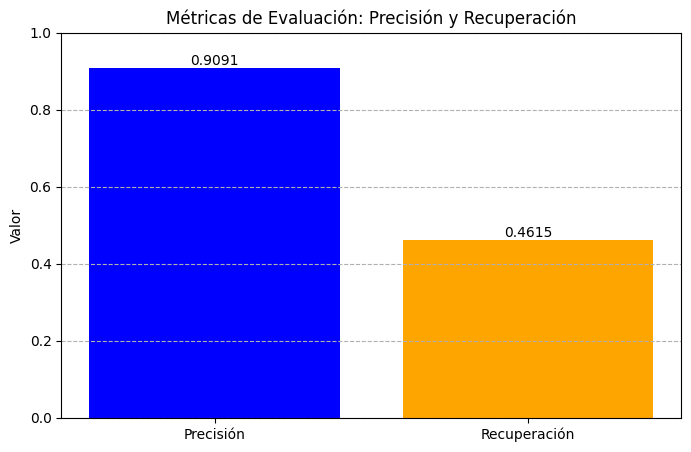

In [103]:
# Resultados
metrics = ['Precisión', 'Recuperación']
values = [precision, recall]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['blue', 'orange'])
plt.ylim(0, 1)  
plt.ylabel('Valor')
plt.title('Métricas de Evaluación: Precisión y Recuperación')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--')
plt.show()

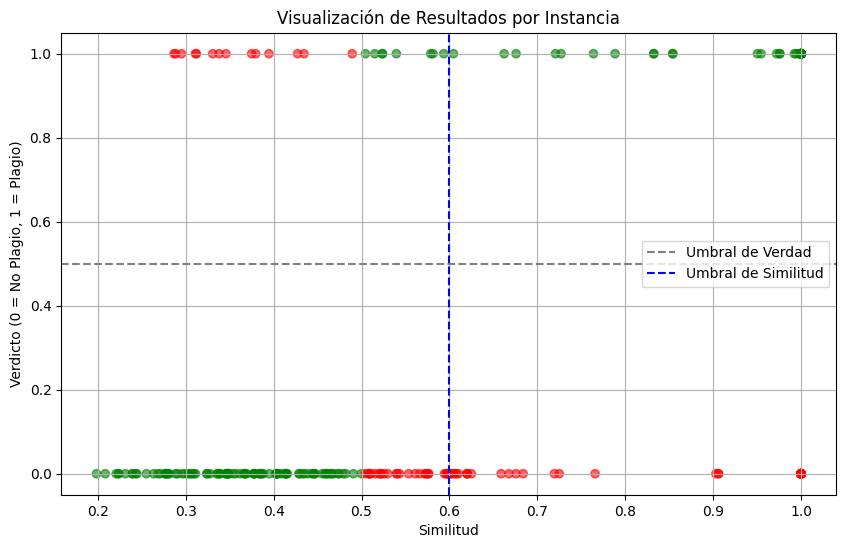

In [104]:
# Una grafica mas

similarity_scores = max_similarity 
y_true = train_pairs['verdict'].values 

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))
colors = ['green' if pred == true else 'red' for pred, true in zip(y_pred, y_true)]
plt.scatter(similarity_scores, y_true, color=colors, alpha=0.6)
plt.axhline(y=0.5, color='gray', linestyle='--', label='Umbral de Verdad')
plt.axvline(x=threshold, color='blue', linestyle='--', label='Umbral de Similitud')
plt.xlabel('Similitud')
plt.ylabel('Verdicto (0 = No Plagio, 1 = Plagio)')
plt.title('Visualización de Resultados por Instancia')
plt.legend()
plt.grid()
plt.show()

In [105]:
# Ahora con mi test

test_pairs[['sub1', 'sub2']] = test_pairs['pair'].str.split('_', expand=True)
test_pairs[['code1', 'code2']] = test_pairs['pair'].apply(lambda x: load_code(x)).apply(pd.Series)

test_codes = test_pairs['code1'].tolist() + test_pairs['code2'].tolist()

test_tfidf_matrix = vectorizer.transform(test_codes)

test_tfidf_code1 = test_tfidf_matrix[:len(test_pairs)]
test_tfidf_code2 = test_tfidf_matrix[len(test_pairs):]

# Calcular la similitud coseno para el conjunto de prueba
test_similarity = cosine_similarity(test_tfidf_code1, test_tfidf_code2)

# Predecir plagio en el conjunto de prueba
test_y_pred_diag = (np.diag(test_similarity) > threshold).astype(int)

# Calcular precisión y recuperación en el conjunto de prueba
test_y_true = test_pairs['verdict'].values
test_precision = precision_score(test_y_true, test_y_pred_diag)
test_recall = recall_score(test_y_true, test_y_pred_diag)

print(f'Precisión en el conjunto de prueba: {test_precision:.4f}')
print(f'Recuperación en el conjunto de prueba: {test_recall:.4f}')


Precisión en el conjunto de prueba: 0.8737
Recuperación en el conjunto de prueba: 0.4462


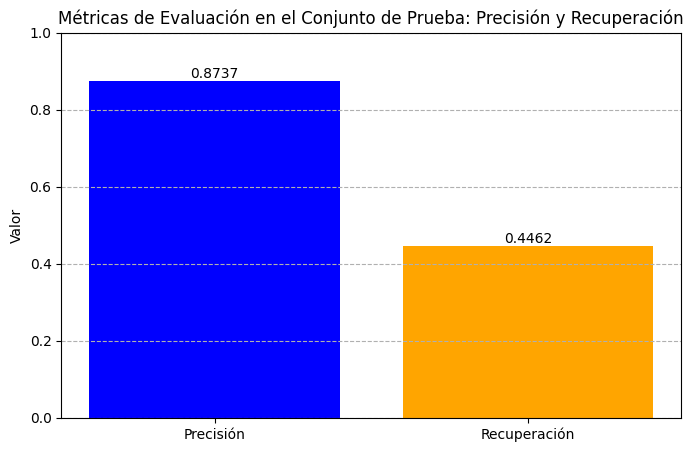

In [106]:
# Resultados del conjunto de prueba
test_metrics = ['Precisión', 'Recuperación']
test_values = [test_precision, test_recall]

plt.figure(figsize=(8, 5))
test_bars = plt.bar(test_metrics, test_values, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Métricas de Evaluación en el Conjunto de Prueba: Precisión y Recuperación')

for bar in test_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')
plt.grid(axis='y', linestyle='--')
plt.show()

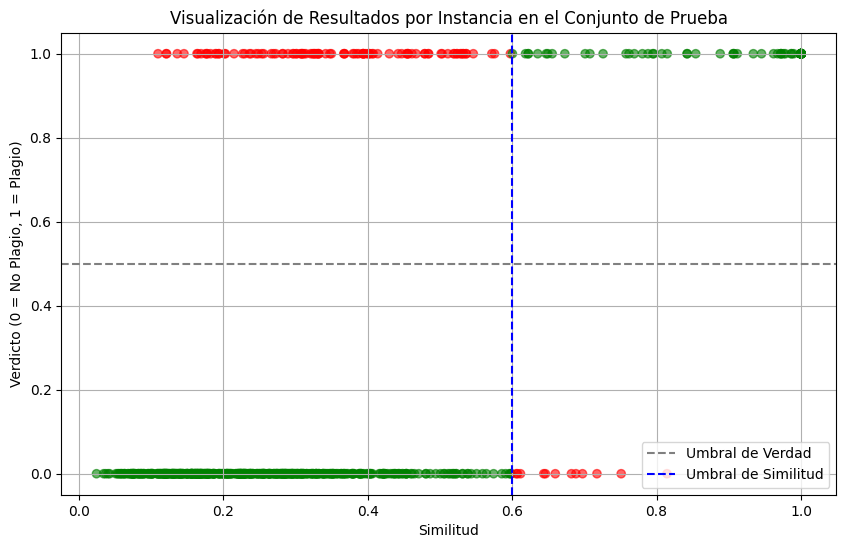

In [107]:
# Visualización de resultados en el conjunto de prueba

test_similarity_scores = np.diag(test_similarity)
test_y_true = test_pairs['verdict'].values

plt.figure(figsize=(10, 6))
test_colors = ['green' if pred == true else 'red' for pred, true in zip(test_y_pred_diag, test_y_true)]
plt.scatter(test_similarity_scores, test_y_true, color=test_colors, alpha=0.6)
plt.axhline(y=0.5, color='gray', linestyle='--', label='Umbral de Verdad')
plt.axvline(x=threshold, color='blue', linestyle='--', label='Umbral de Similitud')
plt.xlabel('Similitud')
plt.ylabel('Verdicto (0 = No Plagio, 1 = Plagio)')
plt.title('Visualización de Resultados por Instancia en el Conjunto de Prueba')
plt.legend()
plt.grid()
plt.show()